# Importy

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import joblib  
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler as _SS

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import os, json, uuid, time, math, random
from pathlib import Path
from sklearn.cluster import KMeans
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler
scaler = GradScaler('cuda')
import wandb
from itertools import product

from sklearn.impute import SimpleImputer
import time
from copy import deepcopy


In [2]:
#cesta
CSV_PATH = Path(r"C:\Users\adria\PycharmProjects\pythonProject\ZNEUS\PROJEKT\houses.csv")
CSV_PATH 

WindowsPath('C:/Users/adria/PycharmProjects/pythonProject/ZNEUS/PROJEKT/houses.csv')

# EDA - Data analysis

### Load dataset

In [3]:
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
display(df.head(10))


Shape: (20640, 9)


,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25
5,269700.0,4.0368,52.0,919.0,213.0,413.0,193.0,37.85,-122.25
6,299200.0,3.6591,52.0,2535.0,489.0,1094.0,514.0,37.84,-122.25
7,241400.0,3.1200,52.0,3104.0,687.0,1157.0,647.0,37.84,-122.25
8,226700.0,2.0804,42.0,2555.0,665.0,1206.0,595.0,37.84,-122.26
9,261100.0,3.6912,52.0,3549.0,707.0,1551.0,714.0,37.84,-122.25


### Dtypes, missing, duplicates

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

In [5]:
print("Dtypes, missing counts")
dtypes_missing = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isna().sum(),
    "missing_rate": (df.isna().mean()).round(4),
    "unique_count": df.nunique(dropna=True)
}).sort_values("missing_count", ascending=False)
display(dtypes_missing)

dups = df.duplicated().sum()
print("Duplicated rows:", dups)


Dtypes, missing counts


,dtype,missing_count,missing_rate,unique_count
median_house_value,float64,0,0.0,3842
median_income,float64,0,0.0,12928
housing_median_age,float64,0,0.0,52
total_rooms,float64,0,0.0,5926
total_bedrooms,float64,0,0.0,1928
population,float64,0,0.0,3888
households,float64,0,0.0,1815
latitude,float64,0,0.0,862
longitude,float64,0,0.0,844


Duplicated rows: 0


### Statistics for numeric columns

In [6]:
num = df.select_dtypes(include=[np.number])
if num.shape[1] > 0:
    display(num.describe().T)
else:
    print("No numeric columns found.")


,count,mean,std,min,25%,50%,75%,max
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.898014,421.247906,1.0000,295.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100


In [7]:
maxv = df['median_house_value'].max()
print("Max value:", maxv, " Count:", (df['median_house_value']==maxv).sum())
df['is_censored'] = (df['median_house_value']==maxv).astype(int)
df['is_censored'].value_counts()


Max value: 500001.0  Count: 965


is_censored
0    19675
1      965
Name: count, dtype: int64

In [8]:
if num.shape[1] > 0:
    iqr = num.quantile(0.75) - num.quantile(0.25)
    range_ = num.max() - num.min()
    outlier_flag = (range_ / (iqr.replace(0, np.nan))).sort_values(ascending=False).head(10)
    print("\nTop features by range / IQR (may indicate heavy tails or outliers):")
    display(outlier_flag)
else:
    print("No numeric columns found.")


Top features by range / IQR (may indicate heavy tails or outliers):


population            38.037313
total_rooms           23.124835
households            18.710769
total_bedrooms        18.306818
median_income          6.651926
median_house_value     3.341960
housing_median_age     2.684211
longitude              2.649077
latitude               2.489418
dtype: float64

### Correlation matrix for numeric features

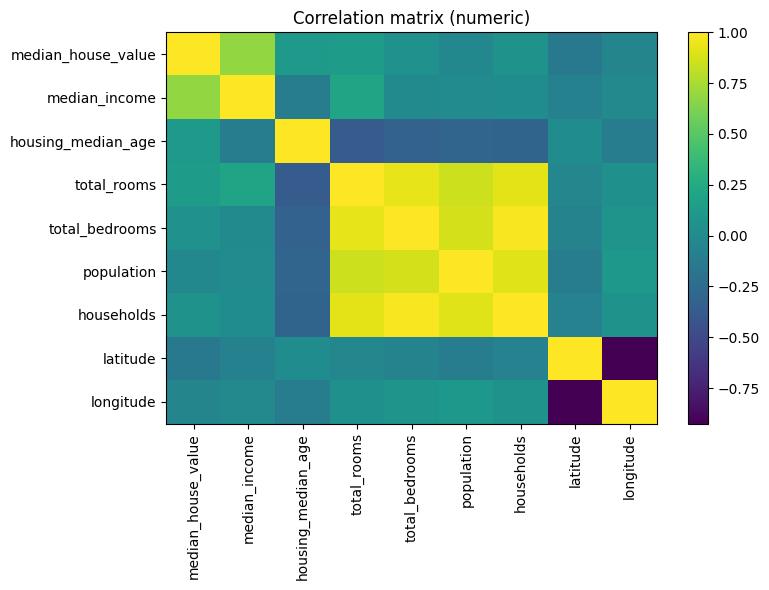

In [9]:
num = df.select_dtypes(include=[np.number]).drop(columns=['is_censored'], errors='ignore')

if num.shape[1] >= 2:
    corr = num.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    plt.imshow(corr, interpolation="nearest", aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation matrix (numeric)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.")


In [10]:
target = "median_house_value"
if target in corr.columns:
    target_corr = corr[target].drop(target).abs().sort_values(ascending=False)
    print("Top features by absolute correlation with target:")
    display(target_corr.head(10))
else:
    print("Target not in numeric columns for correlation.")

Top features by absolute correlation with target:


median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.050594
longitude             0.045967
population            0.024650
Name: median_house_value, dtype: float64

### Target distribution

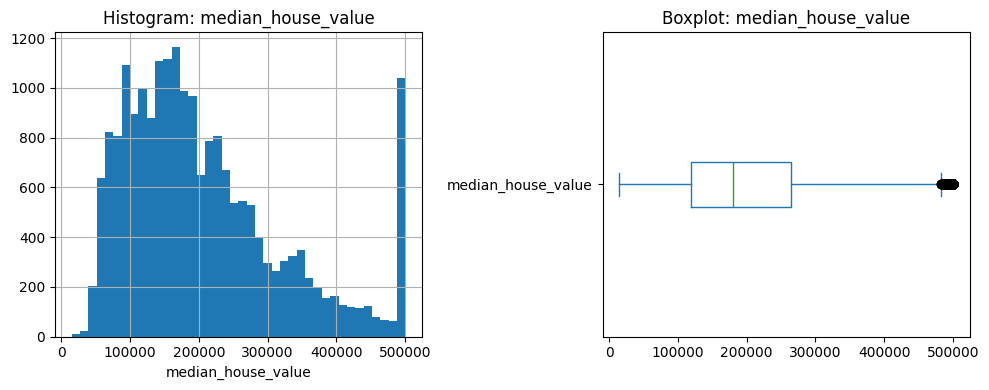

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df[target].dropna().hist(bins=40)
plt.title(f"Histogram: {target}")
plt.xlabel(target)

plt.subplot(1,2,2)
df[target].dropna().plot.box(vert=False)
plt.title(f"Boxplot: {target}")

plt.tight_layout()
plt.show()


In [12]:
skew = num.skew().sort_values(ascending=False)
display(skew)

population            4.935858
total_rooms           4.147343
total_bedrooms        3.453073
households            3.410438
median_income         1.646657
median_house_value    0.977763
latitude              0.465953
housing_median_age    0.060331
longitude            -0.297801
dtype: float64

In [13]:
kurtosis = num.kurtosis().sort_values(ascending=False)
display(kurtosis)

population            73.553116
total_rooms           32.630927
households            22.057988
total_bedrooms        21.923495
median_income          4.952524
median_house_value     0.327870
housing_median_age    -0.800629
latitude              -1.117760
longitude             -1.330152
dtype: float64

#### Scatter and Pair plots for top numeric features correlated with target

Top numeric features vs target: ['median_income', 'latitude', 'total_rooms']


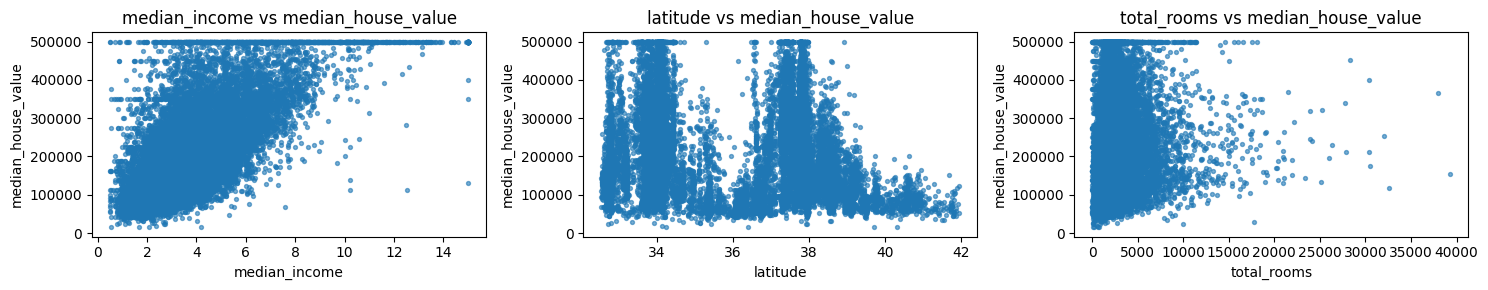

In [14]:
if target in num.columns:
    corr_with_target = num.corr()[target].abs().drop(target).sort_values(ascending=False)
    top_feats = corr_with_target.head(3).index.tolist()
    print("Top numeric features vs target:", top_feats)
    n = len(top_feats)
    if n > 0:
        plt.figure(figsize=(5*n,3))
        for i, f in enumerate(top_feats,1):
            plt.subplot(1,n,i)
            plt.scatter(df[f], df[target], s=8, alpha=0.6)
            plt.xlabel(f); plt.ylabel(target)
            plt.title(f"{f} vs {target}")
        plt.tight_layout()
        plt.show()
else:
    print("Target not numeric or no numeric features.")


### Region exploration

In [15]:
coords = df[['latitude','longitude']]
km = KMeans(n_clusters=8, random_state=0).fit(coords)
df['region_id'] = km.labels_
df.groupby('region_id')['median_house_value'].median().sort_values()


region_id
2     76400.0
4     85800.0
6     89000.0
3    117800.0
7    169650.0
5    181600.0
0    198400.0
1    245100.0
Name: median_house_value, dtype: float64

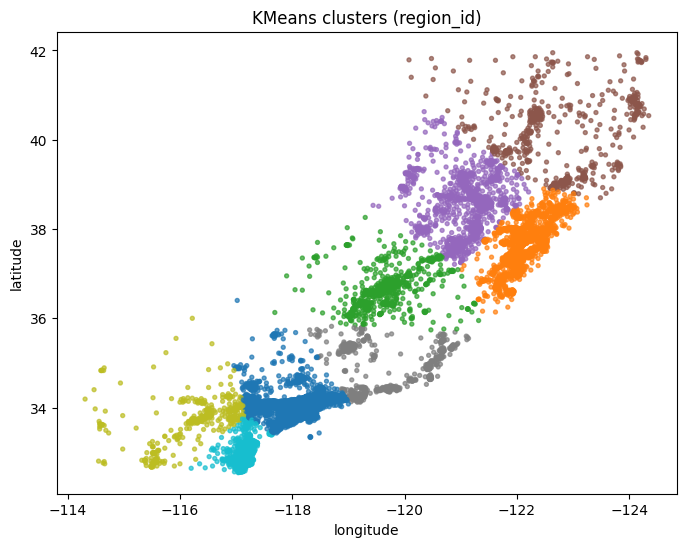

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'], c=df['region_id'], s=8, cmap='tab10', alpha=0.7)
plt.gca().invert_xaxis()
plt.title("KMeans clusters (region_id)")
plt.xlabel("longitude"); plt.ylabel("latitude")
plt.show()

In [17]:
df.groupby('region_id', observed=False)['median_house_value'].agg(['count','median','mean']).sort_values('median')

,count,median,mean
region_id,,,
2,1117,76400.0,86213.249776
4,685,85800.0,92102.916788
6,474,89000.0,106898.529536
3,2203,117800.0,127250.976396
7,1678,169650.0,198141.446365
5,986,181600.0,191438.676471
0,8652,198400.0,229496.027624
1,4845,245100.0,262594.436739


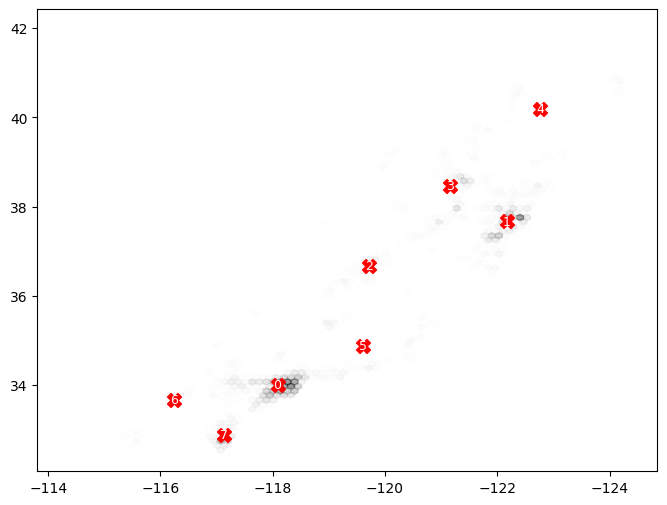

In [18]:
centroids = km.cluster_centers_ 
plt.figure(figsize=(8,6))
plt.hexbin(df["longitude"], df["latitude"], gridsize=80, mincnt=1, cmap='Greys', alpha=0.4)
plt.scatter(centroids[:,1], centroids[:,0], c='red', s=100, marker='X') 
for i,(lon,lat) in enumerate(zip(centroids[:,1], centroids[:,0])):
    plt.text(lon, lat, str(i), color='white', fontsize=9, ha='center', va='center')
plt.gca().invert_xaxis()
plt.show()


### Categorical check

In [19]:
categ = df.select_dtypes(include=["object","category"]).columns.tolist()
if not categ:
    print("No categorical columns found.")
else:
    for c in categ:
        print(f"\nColumn: {c} | Unique: {df[c].nunique()}")
        print(df[c].value_counts().head(5))


No categorical columns found.


### EDA zhrnutie:

- **Veľkosť a čistota dát:** 20 640 riadkov, 9 stĺpcov. V EDA žiadne chýbajúce hodnoty a 0 úplných duplicitných riadkov — dáta sú kompletné a pripravené na ďalšiu analýzu.

- **Cieľ — `median_house_value`:**
  - mean ≈ **206 856**, median ≈ **179 700**, veľký rozptyl.  
  - max = **500001.0**, počet pri maxime = **965**  

- **Hlavné prediktory (lineárne):**
  - `median_income` má najsilnejšiu pozitívnu koreláciu s cenou (~**0.69**) — kľúčový prediktor.  
  - Ďalej sú relevantné priestorové prvky (`latitude`/`longitude`) a štrukturálne metriky domu `total_rooms`...

- **Outliery a šikmosť:**
  - Stĺpce `population`, `total_rooms`, `households`, `total_bedrooms` majú veľký `range / IQR` a vysoký skew → silné chvosty.  
  - `median_house_value` skew ≈ **0.98** (pravostranný).

- **Vizualizácie a priestorový vzor:**
  - Scatter / pairplot potvrdili silný trend `median_income` vs cena a regionálne pásy podľa `latitude`.  
  - Hexbin (longitude vs latitude) ukázal jasné **hotspoty** 

- **Regionálne klastre (KMeans, k=8):**
  - KMeans vytvoril regiony s rôznymi mediánmi
  - Veľkosti klastrov sú nerovnomerné (niektoré stovky, iné tisícky riadkov) — pri použití v modeli zohľadni nerovnomernosť.  
  - Dôležité: KMeans v EDA možno fitnúť na celom df len pre exploráciu


# EXPERIMENTS 1-3

## EXPERIMENT 1

### Data preprocessing and normalization

In [20]:
CONFIG = {}
TARGET = "median_house_value"

EXCLUDE = {TARGET, "is_censored"}
if "region_id" in df.columns:
    EXCLUDE.add("region_id")

FEATURES_NUM = (
    df.drop(columns=[c for c in EXCLUDE if c in df.columns], errors="ignore")
      .select_dtypes(include=[np.number])
      .columns.tolist()
)

CONFIG["features_num"] = FEATURES_NUM

In [21]:
print(f"Target: {TARGET}")
print(f"Počet numerických features: {len(FEATURES_NUM)}")
print("Features:", FEATURES_NUM)

Target: median_house_value
Počet numerických features: 8
Features: ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']


In [22]:
def suggest_log_cols(frame: pd.DataFrame, cols: list[str], skew_threshold: float = 1.0) -> list[str]:
    skew_vals = frame[cols].skew(numeric_only=True)
    return skew_vals[skew_vals.abs() >= skew_threshold].index.tolist()

def make_preprocess(feature_cols: list[str], log_cols: list[str] | None = None):
    if log_cols is None:
        log_cols = []
    other_cols = [c for c in feature_cols if c not in log_cols]

    col_tf = ColumnTransformer(
        transformers=[
            ("log", FunctionTransformer(np.log1p, validate=False), log_cols),
            ("num", "passthrough", other_cols),
        ],
        remainder="drop"
    )
    preprocess = Pipeline([
        ("cols", col_tf),
        ("scaler", StandardScaler()),
    ])
    return preprocess

In [23]:
LOG_COLS_SUGGESTED = suggest_log_cols(df, FEATURES_NUM, skew_threshold=1.0)
print("Návrh log1p stĺpcov (na celej vzorke):", LOG_COLS_SUGGESTED)

Návrh log1p stĺpcov (na celej vzorke): ['median_income', 'total_rooms', 'total_bedrooms', 'population', 'households']


**Čo som spravil**
- Vybral som 8 numerických stĺpcov (bez targetu/cenzúry).
- Na stĺpce s |skew| ≥ 1 som aplikoval `log1p`, potom `StandardScaler`.
- Preprocess som **fitoval len na TRAIN** a použil na VAL/TEST (bez leakage).

**Výsledky**
- Kontroly NaN/Inf ok, rozmery konzistentné.

**Interpretácia**
- `log1p` zmiernil dlhé chvosty a zlepšil stabilitu tréningu MLP.

### Data split

In [24]:
SEED = 42
TEST_SIZE = 0.10
VAL_SIZE  = 0.10
N_BINS    = 10

rng = np.random.RandomState(SEED)

In [25]:
X_all = df[FEATURES_NUM].copy()
y_all = df[TARGET].to_numpy()

y_bins_all = pd.qcut(y_all, q=N_BINS, labels=False, duplicates="drop")

X_trval, X_test, y_trval, y_test, bins_trval, bins_test = train_test_split(
    X_all, y_all, y_bins_all,
    test_size=TEST_SIZE, random_state=SEED, stratify=y_bins_all
)

val_rel = VAL_SIZE / (1.0 - TEST_SIZE)
bins_trval_local = pd.qcut(y_trval, q=N_BINS, labels=False, duplicates="drop")

X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval,
    test_size=val_rel, random_state=SEED, stratify=bins_trval_local
)

print(f"Train: {X_train.shape},  Val: {X_val.shape},  Test: {X_test.shape}")

Train: (16512, 8),  Val: (2064, 8),  Test: (2064, 8)


In [26]:
def _brief_stats(name, y):
    return pd.Series({
        "n":   len(y),
        "mean": float(np.mean(y)),
        "std":  float(np.std(y)),
        "min":  float(np.min(y)),
        "25%":  float(np.quantile(y, 0.25)),
        "50%":  float(np.quantile(y, 0.50)),
        "75%":  float(np.quantile(y, 0.75)),
        "max":  float(np.max(y)),
    }, name=name)

In [27]:
display(pd.concat([
    _brief_stats("train", y_train),
    _brief_stats("val",   y_val),
    _brief_stats("test",  y_test),
], axis=1))

,train,val,test
n,16512.000000,2064.000000,2064.000000
mean,206859.070797,207094.135659,206591.467054
std,115428.240230,115759.619132,114739.638679
min,14999.000000,22500.000000,14999.000000
25%,119400.000000,120950.000000,121225.000000
50%,179700.000000,179700.000000,179750.000000
75%,264700.000000,264825.000000,265350.000000
max,500001.000000,500001.000000,500001.000000


**Čo som spravil**
- Stratifikoval som podľa **kvantilov cieľa** a rozdelil **Train/Val/Test = 80/10/10**.

**Výsledky**
- Tvary ~ **Train (16.5k, 8)**, **Val (2.1k, 8)**, **Test (2.1k, 8)**.

**Interpretácia**
- Udržal som distribúciu cieľa naprieč setmi

### Configuration

In [28]:
CONFIG = {
    "seed": SEED,
    "target": TARGET,
    "data_split": {
        "test_size": TEST_SIZE,
        "val_size": VAL_SIZE,
        "strat_bins": N_BINS,
    },
    "preprocess": {
        "scaler": "standard",
        "auto_log_skew": True,
        "skew_threshold": 1.0,
        "manual_log_cols": [],
    },
    "features": FEATURES_NUM,
}

In [29]:
if CONFIG["preprocess"]["auto_log_skew"]:
    log_cols_final = suggest_log_cols(
        X_train, CONFIG["features"], CONFIG["preprocess"]["skew_threshold"]
    )
else:
    log_cols_final = [c for c in CONFIG["preprocess"]["manual_log_cols"] if c in CONFIG["features"]]

CONFIG["preprocess"]["log_cols"] = log_cols_final
print("log_cols (z TRAIN):", CONFIG["preprocess"]["log_cols"])

log_cols (z TRAIN): ['median_income', 'total_rooms', 'total_bedrooms', 'population', 'households']


In [30]:
cfg_small = {
    "preprocess": CONFIG["preprocess"],
    "data_split": CONFIG.get("data_split"),
    "n_features": len(CONFIG.get("features", [])),
    "features_head": CONFIG.get("features", [])[:10],
}
print(json.dumps(cfg_small, ensure_ascii=False, indent=2))

{
  "preprocess": {
    "scaler": "standard",
    "auto_log_skew": true,
    "skew_threshold": 1.0,
    "manual_log_cols": [],
    "log_cols": [
      "median_income",
      "total_rooms",
      "total_bedrooms",
      "population",
      "households"
    ]
  },
  "data_split": {
    "test_size": 0.1,
    "val_size": 0.1,
    "strat_bins": 10
  },
  "n_features": 8,
  "features_head": [
    "median_income",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "latitude",
    "longitude"
  ]
}


**Čo som spravil**
- Založil som centralizovaný `CONFIG` (seed, features, auto výber log1p, parametre splitu).

**Výsledky**
- Jedno miesto pre celú pipeline.

**Interpretácia**
- Znižuje riziko chýb a zjednodušuje replikáciu.

### Experiment tracking

In [31]:
EXP_HISTORY = []

def log_experiment_mem(params: dict, metrics: dict, notes: str = ""):
    run = {
        "run_id": str(uuid.uuid4())[:8],
        "timestamp": int(time.time()),
        "seed": CONFIG["seed"],
        "notes": notes,
        **{f"p_{k}": v for k, v in params.items()},
        **{f"m_{k}": v for k, v in metrics.items()},
    }
    EXP_HISTORY.append(run)
    return run 

In [32]:
preprocess = make_preprocess(CONFIG["features"], CONFIG["preprocess"]["log_cols"])

Xtr = preprocess.fit_transform(X_train)
Xva = preprocess.transform(X_val)
Xte = preprocess.transform(X_test)

baseline = DummyRegressor(strategy="median")
baseline.fit(Xtr, y_train)

def reg_metrics(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    return {"rmse": rmse, "mae": mae}

In [33]:
m_tr = reg_metrics(y_train, baseline.predict(Xtr))
m_va = reg_metrics(y_val,   baseline.predict(Xva))
m_te = reg_metrics(y_test,  baseline.predict(Xte))

display(pd.DataFrame({"train": m_tr, "val": m_va, "test": m_te}))

,train,val,test
rmse,118580.326232,118956.832885,117848.783127
mae,88360.015686,88658.379845,88002.807171


**Čo som spravil**
- Spustil som `DummyRegressor(strategy="median")` ako nulovú referenciu.

**Výsledky (EUR)**
- **RMSE ~118–119k**, **MAE ~88k** (Val ≈ Test).

**Interpretácia**
- Spodná hranica výkonu pre porovnanie.

### Experiment

In [34]:
DEV = torch.device("cuda:0")

SEED = int(CONFIG.get("seed", 42))
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

In [35]:
WANDB_ENTITY = None
WANDB_PROJECT = "EXPERIMENTS"
WANDB_GROUP = "EXP1-baseline"
os.environ["WANDB_SILENT"] = "true"

print(DEV, "n_features:", Xtr.shape[1])

cuda:0 n_features: 8


In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden=None, batchnorm=True, dropout=0.0):
        super().__init__()
        h = hidden if hidden is not None else max(dim // 2, 16)
        self.bn1  = nn.BatchNorm1d(dim) if batchnorm else nn.Identity()
        self.fc1  = nn.Linear(dim, h)
        self.act  = nn.ReLU()
        self.bn2  = nn.BatchNorm1d(h) if batchnorm else nn.Identity()
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc2  = nn.Linear(h, dim)

    def forward(self, x):
        z = self.bn1(x)
        z = self.fc1(z); z = self.act(z)
        z = self.bn2(z); z = self.drop(z)
        z = self.fc2(z)
        return x + z

In [37]:
class TabularMLP(nn.Module):
    def __init__(self, in_dim, hidden_layers=(128,64,32),
                 batchnorm=True, dropout=0.0,
                 residual=False, bottleneck=False):
        super().__init__()
        dims = [in_dim] + list(hidden_layers)

        if bottleneck and len(hidden_layers) >= 2:
            down = list(hidden_layers)
            up   = list(hidden_layers[:-1])[::-1]
            dims = [in_dim] + down + up

        layers = []
        for i in range(len(dims)-1):
            inp, out = dims[i], dims[i+1]
            layers.append(nn.Linear(inp, out))
            if batchnorm: layers.append(nn.BatchNorm1d(out))
            layers.append(nn.ReLU())
            if dropout > 0: layers.append(nn.Dropout(dropout))
            if residual and out >= 16:
                layers.append(ResidualBlock(out, batchnorm=batchnorm, dropout=dropout))

        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(dims[-1], 1)

    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(1)

In [38]:
SUPPORTS_BF16 = getattr(torch.cuda, "is_bf16_supported", lambda: False)()
AMP_DTYPE = torch.bfloat16 if SUPPORTS_BF16 else torch.float16

def make_loaders(Xtr, ytr, Xva, yva, batch_size=512):
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    ytr_t = torch.tensor(ytr, dtype=torch.float32)
    Xva_t = torch.tensor(Xva, dtype=torch.float32)
    yva_t = torch.tensor(yva, dtype=torch.float32)
    tr = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=batch_size, shuffle=True,  pin_memory=True)
    va = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=batch_size, shuffle=False, pin_memory=True)
    return tr, va

In [39]:
_y_scaler = StandardScaler().fit(y_train.reshape(-1,1))
y_train_s = _y_scaler.transform(y_train.reshape(-1,1)).ravel()
y_val_s   = _y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_s  = _y_scaler.transform(y_test.reshape(-1,1)).ravel()

def _denorm(v):
    return _y_scaler.inverse_transform(np.asarray(v).reshape(-1,1)).ravel()

In [40]:
def reg_metrics_true_units(y_true, y_pred):
    yt = np.asarray(y_true).ravel()
    yp = np.asarray(y_pred).ravel()
    rmse = float(np.sqrt(np.mean((yt - yp) ** 2)))
    mae  = float(np.mean(np.abs(yt - yp)))
    ss_res = float(np.sum((yt - yp) ** 2))
    ss_tot = float(np.sum((yt - np.mean(yt)) ** 2))
    r2 = float(1 - ss_res / (ss_tot + 1e-12))
    return {"rmse": rmse, "mae": mae, "r2": r2}

In [41]:
def train_epoch(model, loader, opt, loss_fn, grad_clip=None, scaler=None):
    model.train()
    losses = []
    for xb, yb in loader:
        xb = xb.to(DEV, non_blocking=True); yb = yb.to(DEV, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with autocast(device_type='cuda', dtype=AMP_DTYPE):
            pred = model(xb)
            loss = loss_fn(pred, yb)
        if scaler is not None:
            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(opt); scaler.update()
        else:
            loss.backward()
            if grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            opt.step()
        losses.append(loss.item())
    return float(np.mean(losses))

In [42]:
@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    losses = []
    y_true_s = []
    y_pred_s = []
    for xb, yb in loader:
        xb = xb.to(DEV, non_blocking=True); yb = yb.to(DEV, non_blocking=True)
        with autocast(device_type='cuda', dtype=AMP_DTYPE):
            pred = model(xb)
            loss = loss_fn(pred, yb)
        losses.append(loss.item())
        y_true_s.append(yb.float().cpu().numpy())
        y_pred_s.append(pred.float().cpu().numpy())

    y_true_s = np.concatenate(y_true_s)
    y_pred_s = np.concatenate(y_pred_s)
    return (float(np.mean(losses)),
            reg_metrics_true_units(_denorm(y_true_s), _denorm(y_pred_s)),
            (_denorm(y_true_s), _denorm(y_pred_s)))

In [43]:
DEFAULT_CFG = dict(
    seed=SEED,
    hidden_layers=[128, 64, 32],
    batchnorm=True,
    dropout=0.10,
    residual=False,
    bottleneck=True,
    optimizer="adam",
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=1024,
    epochs=200,
    patience=20,
    grad_clip=1.0
)

In [44]:
def _init_experiment(cfg, Xtr, ytr_s, Xva, yva_s, wandb_tags=None, run_name=None):
    tr_loader, va_loader = make_loaders(Xtr, ytr_s, Xva, yva_s, batch_size=cfg["batch_size"])

    model = TabularMLP(in_dim=Xtr.shape[1],
                       hidden_layers=tuple(cfg["hidden_layers"]),
                       batchnorm=cfg["batchnorm"], dropout=cfg["dropout"],
                       residual=cfg["residual"], bottleneck=cfg["bottleneck"]).to(DEV)

    if cfg["optimizer"] == "adam":
        opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    elif cfg["optimizer"] == "rmsprop":
        opt = torch.optim.RMSprop(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    else:
        opt = torch.optim.SGD(model.parameters(), lr=cfg["lr"], momentum=0.9, nesterov=True,
                              weight_decay=cfg["weight_decay"])

    loss_fn = nn.MSELoss()
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=max(1, cfg["patience"]//3))
    scaler = GradScaler('cuda') if AMP_DTYPE == torch.float16 else None

    init_kwargs = dict(project=WANDB_PROJECT, group=WANDB_GROUP, name=run_name, config=cfg, tags=wandb_tags)
    run = wandb.init(**init_kwargs)

    return model, opt, loss_fn, sched, scaler, tr_loader, va_loader, run

In [45]:
def _train_with_early_stopping(model, opt, loss_fn, sched, scaler, tr_loader, va_loader, cfg):
    best_val = float("inf")
    best_state = None
    patience_left = cfg["patience"]
    history = []

    for epoch in range(1, cfg["epochs"] + 1):
        tr_loss = train_epoch(model, tr_loader, opt, loss_fn, grad_clip=cfg["grad_clip"], scaler=scaler)
        va_loss, va_m, _ = eval_epoch(model, va_loader, loss_fn)
        sched.step(va_loss)

        history.append({"epoch": epoch, "train_loss_s": tr_loss, "val_loss_s": va_loss,
                        **{f"val_{k}": v for k, v in va_m.items()}})

        wandb.log({
            "epoch": epoch,
            "train_loss_scaled": tr_loss,
            "val_loss_scaled": va_loss,
            "val_rmse": va_m["rmse"],
            "val_mae":  va_m["mae"],
            "val_r2":   va_m["r2"],
            "lr": opt.param_groups[0]["lr"],
        }, step=epoch)

        if va_loss < best_val - 1e-7:
            best_val = va_loss
            patience_left = cfg["patience"]
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    return history, best_state

In [46]:
def _full_eval_and_log(model, cfg, Xtr, ytr_s, Xva, yva_s, Xte, yte_s, run):
    def _full_eval(X, y_s):
        loader = DataLoader(TensorDataset(torch.tensor(X, dtype=torch.float32),
                                          torch.tensor(y_s, dtype=torch.float32)),
                            batch_size=cfg["batch_size"], shuffle=False, pin_memory=True)
        _, m, (yt, yp) = eval_epoch(model, loader, nn.MSELoss())
        return m, (yt, yp)

    tr_m, _ = _full_eval(Xtr, ytr_s)
    va_m, _ = _full_eval(Xva, yva_s)
    te_m, (yt, yp) = _full_eval(Xte, yte_s)

    run.summary.update({
        "train_rmse": tr_m["rmse"], "train_mae": tr_m["mae"], "train_r2": tr_m["r2"],
        "val_rmse":   va_m["rmse"], "val_mae":   va_m["mae"], "val_r2":   va_m["r2"],
        "test_rmse":  te_m["rmse"], "test_mae":  te_m["mae"], "test_r2":  te_m["r2"],
        "epochs_run": len(history) if False else None
    })

    return {"train": tr_m, "val": va_m, "test": te_m}, (yt, yp)

In [47]:
def run_experiment(cfg, Xtr, ytr_s, Xva, yva_s, Xte, yte_s, wandb_tags=None, run_name=None):
    model, opt, loss_fn, sched, scaler, tr_loader, va_loader, run = _init_experiment(
        cfg, Xtr, ytr_s, Xva, yva_s, wandb_tags=wandb_tags, run_name=run_name
    )

    history, best_state = _train_with_early_stopping(model, opt, loss_fn, sched, scaler, tr_loader, va_loader, cfg)

    if best_state is not None:
        model.load_state_dict(best_state)

    res_dict, _ = _full_eval_and_log(model, cfg, Xtr, ytr_s, Xva, yva_s, Xte, yte_s, run)

    run.finish()
    return model, history, res_dict

In [48]:
model_baseline, hist_baseline, res_baseline = run_experiment(
    DEFAULT_CFG,
    Xtr, y_train_s, Xva, y_val_s, Xte, y_test_s,
    wandb_tags=["baseline","bn","dropout","bottleneck"],
    run_name="EXPERIMENT1-baseline"
)

hist_df = pd.DataFrame(hist_baseline)

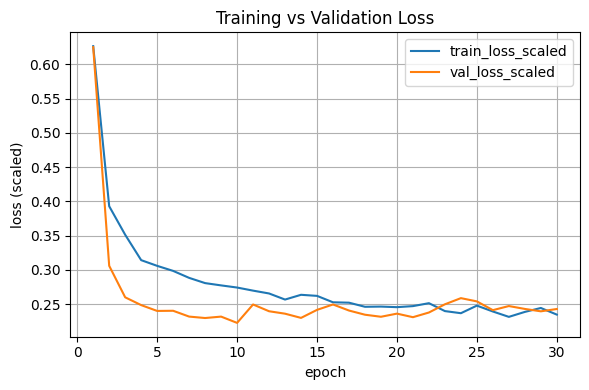

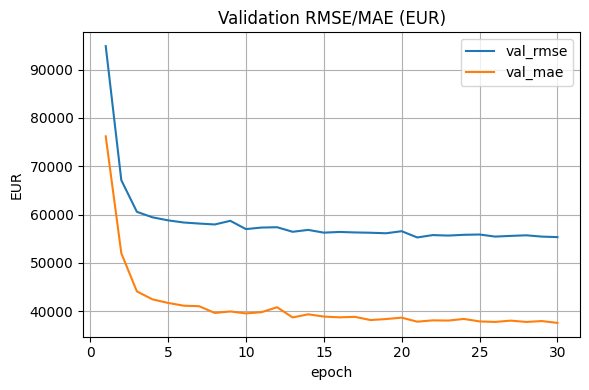

In [49]:
plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["train_loss_s"], label="train_loss_scaled")
plt.plot(hist_df["epoch"], hist_df["val_loss_s"],   label="val_loss_scaled")
plt.xlabel("epoch"); plt.ylabel("loss (scaled)"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["val_rmse"], label="val_rmse")
plt.plot(hist_df["epoch"], hist_df["val_mae"],  label="val_mae")
plt.xlabel("epoch"); plt.ylabel("EUR"); plt.title("Validation RMSE/MAE (EUR)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [50]:
print(pd.DataFrame(res_baseline).round(4))

           train         val        test
rmse  54497.3398  57005.7695  57039.6641
mae   38448.7500  39567.6328  39544.8516
r2        0.7771      0.7575      0.7529


**Čo som spravil**
- MLP `[256,128,64]`, **BatchNorm**, **Dropout ~0.10**, **bottleneck**.
- Optimalizácia: **Adam (LR≈1e-3)**, `ReduceLROnPlateau`, **early stopping**, AMP.

**Výsledky (EUR)**
- Train **~54k**, Val **~57k / ~40k MAE / R² ~0.75–0.76**, Test **~57k / ~40k MAE / R² ~0.75**.

**Interpretácia**
- Val ≈ Test → slušná generalizácia; strop určuje množstvo informácie vo features.

### Hyperparameter search (grid/random) / sweep

In [51]:
search_space = {
    "hidden_layers": [
        [256,128,64],
        [128,64,32],
        [256,128,64,32],
        [128,64,32,64,128],
    ],
    "dropout":      [0.00, 0.05, 0.10, 0.20, 0.30],
    "batchnorm":    [True, False],
    "residual":     [False, True],
    "bottleneck":   [False, True],
    "optimizer":    ["adam","rmsprop","sgd"],
    "lr":           [3e-4, 1e-3],
    "weight_decay": [0.0, 1e-5, 1e-4, 1e-3],
    "batch_size":   [512, 1024, 2048],
    "patience":     [10, 20, 30],
}
WANDB_GROUP = "EXP1-random"

def pick(k):
    return random.choice(search_space[k])

N_TRIALS = 16
random.seed(42)

In [52]:
results = []
best = None

for t in range(1, N_TRIALS + 1):
    cfg = DEFAULT_CFG |{
        "hidden_layers": pick("hidden_layers"),
        "dropout":       pick("dropout"),
        "batchnorm":     pick("batchnorm"),
        "residual":      pick("residual"),
        "bottleneck":    pick("bottleneck"),
        "optimizer":     pick("optimizer"),
        "lr":            pick("lr"),
        "weight_decay":  pick("weight_decay"),
        "batch_size":    pick("batch_size"),
        "patience":      pick("patience"),
        "seed":          random.randint(1, 10_000),
    }

    _, hist_i, res_i = run_experiment(
        cfg,
        Xtr, y_train_s, Xva, y_val_s, Xte, y_test_s,
        wandb_tags=["random-search","EXP1"],
        run_name=f"EXPERIMENT1-rand-{t:02d}"
    )

    row = {
        "trial": t,
        "val_rmse":  res_i["val"]["rmse"],  "val_mae":  res_i["val"]["mae"],  "val_r2":  res_i["val"]["r2"],
        "test_rmse": res_i["test"]["rmse"], "test_mae": res_i["test"]["mae"], "test_r2": res_i["test"]["r2"],
        "cfg": cfg
    }
    results.append(row)
    if best is None or row["val_rmse"] < best["val_rmse"]:
        best = row

res_df = pd.DataFrame(results).sort_values("test_rmse").reset_index(drop=True)

In [53]:
display(res_df[["trial","val_rmse","val_mae","val_r2","test_rmse","test_mae","test_r2"]].round(2))

,trial,val_rmse,val_mae,val_r2,test_rmse,test_mae,test_r2
0,8,54791.94,36329.73,0.78,55026.29,36033.54,0.77
1,13,56024.22,38416.66,0.77,56216.36,38533.17,0.76
2,4,56549.23,37687.66,0.76,56517.07,37022.33,0.76
3,5,56928.77,39401.02,0.76,57257.67,39558.74,0.75
4,6,57498.70,38930.01,0.75,57413.57,38688.31,0.75
5,2,57740.38,39894.01,0.75,57926.43,39826.64,0.75
6,12,57604.21,39773.11,0.75,58262.83,39658.39,0.74
7,3,57445.81,39754.99,0.75,58305.04,39170.13,0.74
8,9,58617.56,40584.36,0.74,58840.70,40284.08,0.74
9,10,59225.02,41836.99,0.74,59555.50,41653.15,0.73


In [113]:
print("\nNajlepší trial (podľa test_rmse):")
print(res_df.iloc[0])

best_cfg = res_df.iloc[0]["cfg"]


Najlepší trial (podľa test_rmse):
trial                                                        8
val_rmse                                          54791.941406
val_mae                                           36329.730469
val_r2                                                0.775963
test_rmse                                         55026.285156
test_mae                                          36033.542969
test_r2                                               0.770008
cfg          {'seed': 8180, 'hidden_layers': [128, 64, 32],...
Name: 0, dtype: object


In [55]:
grid = {
    "hidden_layers": [[256,128,64],[128,64,32]],
    "dropout": [0.05, 0.10],
    "optimizer": ["adam","rmsprop"],
    "lr": [3e-4, 1e-3],
    "weight_decay": [1e-4],
}
WANDB_GROUP = "EXP1-grid"

grid_keys = list(grid.keys())
grid_vals = list(grid.values())

grid_results = []
i = 0
for values in product(*grid_vals):
    i += 1
    cfg = DEFAULT_CFG | {k: v for k, v in zip(grid_keys, values)}
    _, _, res_i = run_experiment(
        cfg, Xtr, y_train_s, Xva, y_val_s, Xte, y_test_s,
        wandb_tags=["grid-search"], run_name=f"EXPERIMENT1-grid-{i:02d}"
    )
    grid_results.append({"i": i, "cfg": cfg, "val_rmse": res_i["val"]["rmse"], "test_rmse": res_i["test"]["rmse"]})

In [56]:
pd.DataFrame(grid_results).sort_values("test_rmse").head(10)

,i,cfg,val_rmse,test_rmse
7,8,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",54629.953125,54573.812500
13,14,"{'seed': 42, 'hidden_layers': [128, 64, 32], '...",55659.156250,55346.910156
9,10,"{'seed': 42, 'hidden_layers': [128, 64, 32], '...",54728.906250,55499.867188
0,1,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",55478.167969,55684.269531
5,6,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",55481.292969,55721.011719
2,3,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",55649.648438,55829.703125
6,7,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",56063.800781,56844.382812
8,9,"{'seed': 42, 'hidden_layers': [128, 64, 32], '...",57240.386719,57116.785156
10,11,"{'seed': 42, 'hidden_layers': [128, 64, 32], '...",57204.406250,57190.980469
4,5,"{'seed': 42, 'hidden_layers': [256, 128, 64], ...",57705.449219,57651.160156


<!-- Poznámky k časti Hyperparameter search

Random search je jednoduchý a účinný pre tabuľky; každý trial je samostatný W&B run (ľahké porovnanie vo W&B Tables/Charts).

Zahrnuté techniky: Dropout, BatchNorm, Residual bloky, Bottleneck; testujeme aj optimizers (Adam/RMSProp/SGD) a LR/weight decay/batch.

(Voliteľne) Grid nad zúženým priestorom pre „posledné doladenie“.

„Best“ si vieš zobrať cez best_cfg a pustiť ešte raz s dlhším tréningom. -->

### Hyperparameter search (random)
**Čo som spravil**
- Spustil som 16 náhodných behov cez vrstvy, dropout, BN, residual/bottleneck, optimizer, LR, WD, batch, patience.

**Výsledky (EUR)**
- Najlepšie **Val RMSE ~54–55k**, **Test ~55k**.

**Interpretácia**
- Víťazia **Adam + LR ~1e-3**, dropout **0.05–0.10**, nízky WD.

### Hyperparameter search (grid)
**Čo som spravil**
- Zúžil som grid okolo top nastavení z randomu.

**Výsledky (EUR)**
- Najlepšie **Val ~54.6k**, **Test ~54.6k**.

**Interpretácia**
- Nastavenie stabilné; ďalší progres potrebuje bohatšie vstupy.


## EXPERIMENT 2

### Data preprocessing and normalization

In [57]:
TARGET = "median_house_value"

EXCLUDE_E2 = {TARGET, "is_censored"}
if "region_id" in df.columns:
    EXCLUDE_E2.add("region_id")

CANDIDATES_E2 = (
    df.drop(columns=[c for c in EXCLUDE_E2 if c in df.columns], errors="ignore")
      .select_dtypes(include=[np.number]).columns.tolist()
)

In [58]:
print("EXP2 kandidáti:", CANDIDATES_E2)

EXP2 kandidáti: ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude', 'longitude']


In [59]:
def select_top_raw_by_corr(frame: pd.DataFrame, target_col: str, k: int = 4) -> list[str]:
    corr = frame[CANDIDATES_E2 + [target_col]].corr(numeric_only=True)[target_col]
    return corr.drop(target_col).abs().sort_values(ascending=False).head(k).index.tolist()

In [60]:
def suggest_log_cols_for(frame: pd.DataFrame, cols: list[str], skew_threshold: float = 1.0) -> list[str]:
    s = frame[cols].skew(numeric_only=True)
    return s[s.abs() >= skew_threshold].index.tolist()

In [61]:
def make_preprocess(feature_cols: list[str], log_cols: list[str] | None = None):
    log_cols = [] if log_cols is None else list(log_cols)
    other    = [c for c in feature_cols if c not in log_cols]
    col_tf = ColumnTransformer(
        transformers=[
            ("log",  FunctionTransformer(np.log1p, validate=False), log_cols),
            ("num",  "passthrough", other),
        ],
        remainder="drop",
    )
    return Pipeline([("cols", col_tf), ("scaler", StandardScaler())])

**Čo som spravil**
- Z 8 kandidátov som vybral **Top-4 podľa |corr| s cieľom** na TRAINE.
- `log1p` len pre stĺpce s **|skew| ≥ 1** (určené na TRAINE), potom `StandardScaler`.

**Výsledky**
- Typické Top-4: `median_income`, `latitude`, `total_rooms`, `housing_median_age`.

**Interpretácia**
- Menšia dimenzia zrýchľuje tréning, ale znižuje maximálnu presnosť.

### Data split

In [62]:
SEED = 42
TEST_FRAC = 0.10
VAL_FRAC  = 0.10

X_all = df[CANDIDATES_E2].copy()
y_all = df[TARGET].to_numpy()

bins_all = pd.qcut(y_all, q=10, labels=False, duplicates="drop")

In [63]:
X_trval, X_test2, y_trval, y_test2, bins_trval, bins_test = train_test_split(
    X_all, y_all, bins_all, test_size=TEST_FRAC, random_state=SEED, stratify=bins_all
)

val_rel = VAL_FRAC / (1.0 - TEST_FRAC)
bins_trval_local = pd.qcut(y_trval, q=10, labels=False, duplicates="drop")
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_trval, y_trval, test_size=val_rel, random_state=SEED, stratify=bins_trval_local
)

In [64]:
print(f"EXP2 shapes | train: {X_train2.shape}  val: {X_val2.shape}  test: {X_test2.shape}")

EXP2 shapes | train: (16512, 8)  val: (2064, 8)  test: (2064, 8)


In [65]:
y_train2_ser = pd.Series(y_train2, index=X_train2.index, name=TARGET)

corr_tbl = (
    pd.concat([X_train2[CANDIDATES_E2], y_train2_ser], axis=1)
      .corr(numeric_only=True)[TARGET]
      .drop(TARGET)
      .reindex(CANDIDATES_E2)
)

In [66]:
print("EXP2 |corr| (TRAIN) – top 8:")
display(corr_tbl.abs().sort_values(ascending=False).to_frame("abs_corr").head(8))

EXP2 |corr| (TRAIN) – top 8:


,abs_corr
median_income,0.692729
latitude,0.146938
total_rooms,0.136981
housing_median_age,0.103472
households,0.064002
total_bedrooms,0.049039
longitude,0.044149
population,0.025028


In [67]:
TOP4_E2 = corr_tbl.abs().sort_values(ascending=False).head(4).index.tolist()
print("EXP2 Top-4 (TRAIN |corr|):", TOP4_E2)

EXP2 Top-4 (TRAIN |corr|): ['median_income', 'latitude', 'total_rooms', 'housing_median_age']


In [68]:
LOG_E2 = X_train2[TOP4_E2].skew(numeric_only=True).abs().pipe(lambda s: s[s >= 1.0].index.tolist())
print("EXP2 log_cols (TRAIN):", LOG_E2)

EXP2 log_cols (TRAIN): ['median_income', 'total_rooms']


**Čo som spravil**
- Použil som rovnakú kvantilovú stratifikáciu.

**Výsledky**
- Po preprocese: **Train (16.5k, 4)**, **Val (2.1k, 4)**, **Test (2.1k, 4)**.

**Interpretácia**
- Čisté porovnanie proti E1, zmena je len v počte vstupov.

### Configuration

In [69]:
CONFIG_E2 = {
    "seed": SEED,
    "target": TARGET,
    "features": TOP4_E2,       
    "preprocess": {
        "scaler": "standard",
        "log_cols": LOG_E2,
    },
    "feature_set": "exp2_top4",
}

In [70]:
preprocess_e2 = make_preprocess(CONFIG_E2["features"], CONFIG_E2["preprocess"]["log_cols"])
Xtr_e2 = preprocess_e2.fit_transform(X_train2)
Xva_e2 = preprocess_e2.transform(X_val2)
Xte_e2 = preprocess_e2.transform(X_test2)

print("EXP2 n_features:", Xtr_e2.shape[1])

EXP2 n_features: 4


**Čo som spravil**
- Nastavil som `features = TOP4`, `log_cols` zo skew na TRAINE, `scaler="standard"`.

**Výsledky**
- Prehľadné a opakovateľné nastavenie.

**Interpretácia**
- Umožňuje zmerať kompromis „menej features vs. výkon“.

### Experiment tracking

In [71]:
baseline_e2 = DummyRegressor(strategy="median").fit(Xtr_e2, y_train2)

def _m(y_t, y_p): 
    return {"rmse": float(np.sqrt(mean_squared_error(y_t, y_p))),
            "mae":  float(mean_absolute_error(y_t, y_p)),
            "r2":   float(r2_score(y_t, y_p))}

m_tr_e2 = _m(y_train2, baseline_e2.predict(Xtr_e2))
m_va_e2 = _m(y_val2,   baseline_e2.predict(Xva_e2))
m_te_e2 = _m(y_test2,  baseline_e2.predict(Xte_e2))

In [72]:
display(pd.DataFrame({"train": m_tr_e2, "val": m_va_e2, "test": m_te_e2}).round(2))

,train,val,test
rmse,118580.33,118956.83,117848.78
mae,88360.02,88658.38,88002.81
r2,-0.06,-0.06,-0.05


**Čo som spravil**
- Spustil som dummy medián ako referenčný model.

**Výsledky (EUR)**
- **RMSE ~118–119k**, **MAE ~88k**.

**Interpretácia**
- Slúži len ako spodná hranica.

### Experiments

In [73]:
y_scaler = StandardScaler().fit(y_train2.reshape(-1,1))
y_train2_s = y_scaler.transform(y_train2.reshape(-1,1)).ravel()
y_val2_s   = y_scaler.transform(y_val2.reshape(-1,1)).ravel()
y_test2_s  = y_scaler.transform(y_test2.reshape(-1,1)).ravel()

CFG_E2 = DEFAULT_CFG | {"feature_set": CONFIG_E2["feature_set"]}

WANDB_GROUP = "EXP2-baseline"

tags = [CFG_E2["feature_set"], "baseline", "EXP2_top4"]
model_e2, hist_e2, res_e2 = run_experiment(
    CFG_E2, Xtr_e2, y_train2_s, Xva_e2, y_val2_s, Xte_e2, y_test2_s,
    wandb_tags=tags, run_name="EXPERIMENT2-baseline"
)

In [74]:
display(pd.DataFrame(res_e2).round(2))

,train,val,test
rmse,71332.88,72996.13,75179.42
mae,52076.80,53342.20,54484.72
r2,0.62,0.60,0.57


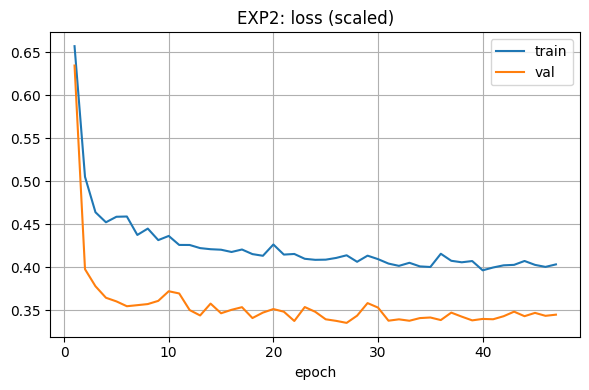

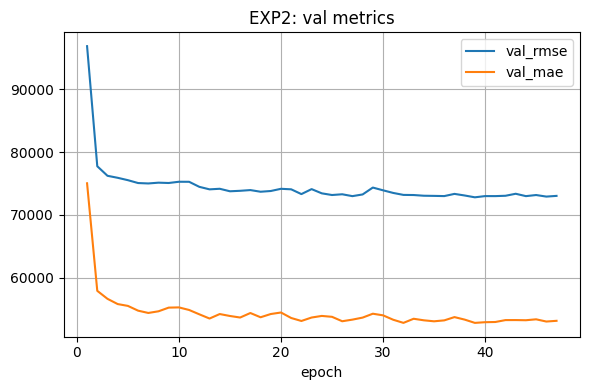

In [75]:
hd = pd.DataFrame(hist_e2)
plt.figure(figsize=(6,4))
plt.plot(hd["epoch"], hd["train_loss_s"], label="train"); plt.plot(hd["epoch"], hd["val_loss_s"], label="val")
plt.title("EXP2: loss (scaled)"); plt.xlabel("epoch"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hd["epoch"], hd["val_rmse"], label="val_rmse"); plt.plot(hd["epoch"], hd["val_mae"], label="val_mae")
plt.title("EXP2: val metrics"); plt.xlabel("epoch"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

**Čo som spravil**
- Trénoval som MLP ako v E1, ale so 4 vstupmi.

**Výsledky (EUR)**
- Train **~71k**, Val **~73k / ~53k MAE / R² ~0.60**, Test **~75k / ~55k MAE / R² ~0.57**.

**Interpretácia**
- Jasný pokles presnosti (menej informácií), bez výrazného overfitu.

### Hyperparameter search (grid/random)

In [76]:
search_space = {
    "hidden_layers": [[256,128,64],[128,64,32],[256,128,64,32]],
    "dropout":      [0.00, 0.05, 0.10, 0.20, 0.30],
    "batchnorm":    [True, False],
    "residual":     [False, True],
    "bottleneck":   [False, True],
    "optimizer":    ["adam","rmsprop","sgd"],
    "lr":           [3e-4, 1e-3],
    "weight_decay": [0.0, 1e-5, 1e-4, 1e-3],
    "batch_size":   [512, 1024, 2048],
    "patience":     [10, 20, 30],
}
def _pick(k): 
    return random.choice(search_space[k])

N_TRIALS = 16

WANDB_GROUP = "EXP2-random"
rows = []

In [77]:
for i in range(1, N_TRIALS+1):
    cfg = DEFAULT_CFG |{
        "hidden_layers": _pick("hidden_layers"),
        "dropout":      _pick("dropout"),
        "batchnorm":    _pick("batchnorm"),
        "residual":     _pick("residual"),
        "bottleneck":   _pick("bottleneck"),
        "optimizer":    _pick("optimizer"),
        "lr":           _pick("lr"),
        "weight_decay": _pick("weight_decay"),
        "batch_size":   _pick("batch_size"),
        "patience":     _pick("patience"),
        "seed":         random.randint(1, 10_000),
        "feature_set":  CONFIG_E2["feature_set"],
    }

    model_tmp, hist_tmp, res = run_experiment(
        cfg,
        Xtr_e2, y_train2_s,
        Xva_e2, y_val2_s,
        Xte_e2, y_test2_s,
        wandb_tags=[CONFIG_E2["feature_set"], "random", "EXP2_top4"],
        run_name=f"EXPERIMENT2-rand-{i:02d}"
    )

    rows.append({
        "i": i,
        "val_rmse": res["val"]["rmse"],
        "test_rmse": res["test"]["rmse"],
        "val_mae": res["val"]["mae"],
        "test_mae": res["test"]["mae"],
        "cfg": cfg
    })

In [78]:
df_rows = pd.DataFrame(rows)
display(df_rows.sort_values("test_rmse").head(10).round(3))

,i,val_rmse,test_rmse,val_mae,test_mae,cfg
12,13,71835.086,74327.703,51693.031,53171.566,"{'seed': 9065, 'hidden_layers': [256, 128, 64,..."
7,8,72054.359,74699.164,51976.797,53540.156,"{'seed': 1313, 'hidden_layers': [256, 128, 64]..."
10,11,72479.062,74782.102,52424.629,53674.266,"{'seed': 3493, 'hidden_layers': [256, 128, 64,..."
3,4,72665.438,74784.359,52597.496,53724.598,"{'seed': 3007, 'hidden_layers': [256, 128, 64]..."
5,6,72186.891,74867.141,52246.438,53532.004,"{'seed': 6210, 'hidden_layers': [256, 128, 64]..."
11,12,72363.711,74871.070,51527.621,53107.270,"{'seed': 8901, 'hidden_layers': [256, 128, 64,..."
14,15,72876.375,75064.609,52569.480,53867.004,"{'seed': 7240, 'hidden_layers': [256, 128, 64,..."
6,7,73293.875,75098.992,53534.516,54463.727,"{'seed': 3567, 'hidden_layers': [256, 128, 64]..."
2,3,72951.438,75746.203,53243.148,54508.277,"{'seed': 1613, 'hidden_layers': [256, 128, 64]..."
8,9,72767.305,75867.297,52201.207,54089.820,"{'seed': 6869, 'hidden_layers': [256, 128, 64]..."


In [79]:
grid = {
    "hidden_layers": [[256,128,64],[128,64,32]],
    "dropout": [0.00, 0.10],
    "optimizer": ["adam","rmsprop"],
    "lr": [3e-4, 1e-3],
    "weight_decay": [1e-4],
}

WANDB_GROUP = "EXP2-grid"

gkeys, gvals = list(grid.keys()), list(grid.values())
rows = []
idx = 1

In [80]:
for values in product(*gvals):
    cfg = DEFAULT_CFG | {k: v for k, v in zip(gkeys, values)} | {"feature_set": CONFIG_E2["feature_set"], "seed": 42 + idx}
    _, _, res = run_experiment(
        cfg,
        Xtr_e2, y_train2_s,
        Xva_e2, y_val2_s,
        Xte_e2, y_test2_s,
        wandb_tags=[CONFIG_E2["feature_set"], "grid", "EXP2_top4"],
        run_name=f"EXPERIMENT2-grid-{idx:02d}"
    )
    rows.append({"i": idx, "val_rmse": res["val"]["rmse"], "test_rmse": res["test"]["rmse"], "cfg": cfg})
    idx += 1

In [81]:
pd.DataFrame(rows).sort_values("test_rmse").head(10).round(2)

,i,val_rmse,test_rmse,cfg
3,4,71510.12,74957.34,"{'seed': 46, 'hidden_layers': [256, 128, 64], ..."
5,6,72466.07,75001.33,"{'seed': 48, 'hidden_layers': [256, 128, 64], ..."
6,7,72932.16,75167.34,"{'seed': 49, 'hidden_layers': [256, 128, 64], ..."
13,14,73295.26,75231.13,"{'seed': 56, 'hidden_layers': [128, 64, 32], '..."
15,16,73484.59,75568.80,"{'seed': 58, 'hidden_layers': [128, 64, 32], '..."
7,8,73273.70,75688.66,"{'seed': 50, 'hidden_layers': [256, 128, 64], ..."
4,5,73258.41,75735.23,"{'seed': 47, 'hidden_layers': [256, 128, 64], ..."
2,3,73179.38,75812.38,"{'seed': 45, 'hidden_layers': [256, 128, 64], ..."
9,10,73138.76,75979.05,"{'seed': 52, 'hidden_layers': [128, 64, 32], '..."
1,2,73023.39,76037.55,"{'seed': 44, 'hidden_layers': [256, 128, 64], ..."


#### Hyperparameter search (random)
**Čo som spravil**
- Spustil som 16 náhodných behov.

**Výsledky (EUR)**
- Najlepšie **Val ~71–72k**, **Test ~74–75k**.

**Interpretácia**
- Limit je v chudobnejšom featuringu, nie v nastaveniach.

#### Hyperparameter search (grid)
**Čo som spravil**
- Zúžil som grid okolo najlepších kombinácií.

**Výsledky (EUR)**
- Najlepšie **Val ~71.5k**, **Test ~75k**.

**Interpretácia**
- Potvrdzuje kompromis E2; na zlepšenie treba nové/features.

## EXPERIMENT 3

### Data preprocessing and normalization

In [82]:
TARGET = "median_house_value"
SEED = 42
K = 8

NUM_FEATURES = (
    df.drop(columns=[c for c in [TARGET, "is_censored", "region_id"] if c in df.columns], errors="ignore")
      .select_dtypes(include=[np.number])
      .columns.tolist()
)

In [83]:
def suggest_log_cols(frame: pd.DataFrame, cols: list[str], skew_threshold: float = 1.0) -> list[str]:
    s = frame[cols].skew(numeric_only=True)
    return s[s.abs() >= skew_threshold].index.tolist()

In [84]:
def fit_geo_kmeans(Xtr_base: pd.DataFrame, n_clusters: int = K, seed: int = SEED):
    km = KMeans(n_clusters=n_clusters, random_state=seed, n_init=10)
    km.fit(Xtr_base[["latitude", "longitude"]].to_numpy())
    return km

In [85]:
def assign_regions(km, df_base: pd.DataFrame):
    rid = km.predict(df_base[["latitude", "longitude"]].to_numpy())
    reg = pd.get_dummies(pd.Series(rid, index=df_base.index), prefix="region", dtype=np.int8)
    for i in range(K):
        c = f"region_{i}"
        if c not in reg.columns:
            reg[c] = 0
    reg = reg[[f"region_{i}" for i in range(K)]]
    out = pd.concat([df_base, reg], axis=1)
    assert len(out) == len(df_base) and out.index.equals(df_base.index)
    return out, rid

In [86]:
def compute_region_stats(rid_tr: np.ndarray, y_train: np.ndarray, index: pd.Index):
    y_tr_ser = pd.Series(y_train, index=index, name=TARGET)
    grp = pd.DataFrame({"region": rid_tr, TARGET: y_tr_ser.values}, index=index).groupby("region")
    r_mean  = grp[TARGET].mean()
    r_count = grp[TARGET].count()
    r_rankn = r_mean.rank(method="dense", ascending=True).astype(int)
    r_rankn = (r_rankn / r_rankn.max()).to_dict()
    return r_mean, r_count, r_rankn

In [87]:
def map_stats_to_df(df_out: pd.DataFrame, rid: np.ndarray, r_mean: pd.Series, r_count: pd.Series, r_rankn: dict):
    df_out["region_mean"] = pd.Series(rid, index=df_out.index).map(r_mean).fillna(r_mean.mean()).astype(float)
    df_out["region_size"] = pd.Series(rid, index=df_out.index).map(r_count).fillna(0).astype(float)
    df_out["region_rank"] = pd.Series(rid, index=df_out.index).map(r_rankn).fillna(0).astype(float)

In [88]:
def add_geo_interactions(*dfs):
    for d in dfs:
        if "median_income" in d.columns:
            d["income_lat"] = d["median_income"] * d["latitude"]
            d["income_lon"] = d["median_income"] * d["longitude"]
        d["lat2"] = d["latitude"] ** 2
        d["lon2"] = d["longitude"] ** 2
        d["lat_lon"] = d["latitude"] * d["longitude"]

In [89]:
def build_geo_blocks(Xtr_base: pd.DataFrame, Xva_base: pd.DataFrame, Xte_base: pd.DataFrame, y_train: np.ndarray):
    km = fit_geo_kmeans(Xtr_base)
    Xtr_r, rid_tr = assign_regions(km, Xtr_base)
    Xva_r, rid_va = assign_regions(km, Xva_base)
    Xte_r, rid_te = assign_regions(km, Xte_base)

    r_mean, r_count, r_rankn = compute_region_stats(rid_tr, y_train, Xtr_base.index)

    map_stats_to_df(Xtr_r, rid_tr, r_mean, r_count, r_rankn)
    map_stats_to_df(Xva_r, rid_va, r_mean, r_count, r_rankn)
    map_stats_to_df(Xte_r, rid_te, r_mean, r_count, r_rankn)

    add_geo_interactions(Xtr_r, Xva_r, Xte_r)
    return Xtr_r, Xva_r, Xte_r

**Čo som spravil**
- Zobral som všetky numerické + pridal **geo-bloky**: KMeans(k≈8) na (lat,lon) → one-hot `region_*`.
- Z TRAINU som vypočítal regionálne štatistiky (`region_mean`, `region_size`, `region_rank`) a **interakcie** (`income_lat`, `income_lon`, `lat2`, `lon2`, `lat_lon`).
- `log1p` som aplikoval pre **nezáporné** stĺpce s **|skew| ≥ 1** (TRAINE) + `StandardScaler`.

**Výsledky**
- Po dedupe ~**24 vstupov**; preprocess fit len na TRAINE.

**Interpretácia**
- Geoinformácia výrazne pomáha — lepší signál o lokalite a hustote.

### Data split

In [90]:
TEST_FRAC = 0.10
VAL_FRAC  = 0.10

X_all = df[NUM_FEATURES].copy()
y_all = df[TARGET].to_numpy()

bins_all = pd.qcut(y_all, q=10, labels=False, duplicates="drop")

X_trval, X_test3, y_trval, y_test3, bins_trval, bins_test = train_test_split(
    X_all, y_all, bins_all, test_size=TEST_FRAC, random_state=SEED, stratify=bins_all
)

In [91]:
val_rel = VAL_FRAC / (1.0 - TEST_FRAC)
bins_trval_local = pd.qcut(y_trval, q=10, labels=False, duplicates="drop")
X_train3, X_val3, y_train3, y_val3 = train_test_split(
    X_trval, y_trval, test_size=val_rel, random_state=SEED, stratify=bins_trval_local
)

In [92]:
print(f"EXP3 shapes | train: {X_train3.shape}  val: {X_val3.shape}  test: {X_test3.shape}")

X_train3_full, X_val3_full, X_test3_full = build_geo_blocks(X_train3, X_val3, X_test3, y_train3)

EXP3 shapes | train: (16512, 8)  val: (2064, 8)  test: (2064, 8)


In [93]:
GEO_COLS = [c for c in X_train3_full.columns if c.startswith("region_")] + \
           [c for c in ["region_mean","region_size","region_rank",
                        "income_lat","income_lon","lat2","lon2","lat_lon"] if c in X_train3_full.columns]
FEATURES_E3 = [c for c in NUM_FEATURES if c in X_train3_full.columns] + GEO_COLS

In [94]:
def suggest_log_cols_for(df_tr: pd.DataFrame, cand_cols, skew_threshold=1.0):
    s = df_tr[cand_cols].skew(numeric_only=True).abs()
    return s[s >= skew_threshold].index.tolist()

CAND_LOG = [c for c in FEATURES_E3 if c in X_train3_full.columns and X_train3_full[c].min() >= 0]

LOG_E3 = suggest_log_cols_for(X_train3_full, CAND_LOG, skew_threshold=1.0)

In [95]:
print("EXP3 n_features (pred dedupe):", len(FEATURES_E3))
print("EXP3 log_cols (TRAIN):", LOG_E3)

EXP3 n_features (pred dedupe): 27
EXP3 log_cols (TRAIN): ['median_income', 'total_rooms', 'total_bedrooms', 'population', 'households', 'region_0', 'region_1', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7', 'income_lat']


**Čo som spravil**
- Použil som rovnakú stratifikáciu; KMeans a mapovanie štatistík som **fitoval len na TRAINE**, aplikoval na VAL/TEST.

**Výsledky**
- Po preprocese: **Train (16.5k, ~24)**, **Val (2.1k, ~24)**, **Test (2.1k, ~24)**.

**Interpretácia**
- Minimalizovaný leakage

### Configuration

In [96]:
seen=set(); FEATURES_E3_unique=[]
for c in FEATURES_E3:
    if c not in seen:
        FEATURES_E3_unique.append(c); seen.add(c)
LOG_E3 = [c for c in LOG_E3 if c in FEATURES_E3_unique]

CONFIG_E3 = {
    "seed": SEED,
    "target": TARGET,
    "features": FEATURES_E3_unique,
    "preprocess": {"scaler": "standard", "log_cols": LOG_E3},
    "feature_set": "exp3_allnum_geo",
}
print("EXP3 n_features (po dedupe):", len(CONFIG_E3["features"]))

EXP3 n_features (po dedupe): 24


In [97]:
def make_preprocess_e3(feature_cols: list[str], log_cols: list[str]):
    other_cols = [c for c in feature_cols if c not in log_cols]
    col_tf = ColumnTransformer(
        transformers=[
            ("log",  Pipeline([("imp", SimpleImputer(strategy="median")),
                               ("log", FunctionTransformer(np.log1p, validate=False))]), log_cols),
            ("num",  SimpleImputer(strategy="median"), other_cols),
        ],
        remainder="drop",
    )
    return Pipeline([
        ("cols", col_tf),
        ("scaler", StandardScaler()),
    ])

In [98]:
def make_preprocess_e3(feature_cols: list[str], log_cols: list[str]):
    other_cols = [c for c in feature_cols if c not in log_cols]
    col_tf = ColumnTransformer(
        transformers=[
            ("log",  Pipeline([("imp", SimpleImputer(strategy="median")),
                               ("log", FunctionTransformer(np.log1p, validate=False))]), log_cols),
            ("num",  SimpleImputer(strategy="median"), other_cols),
        ],
        remainder="drop",
    )
    return Pipeline([
        ("cols", col_tf),
        ("scaler", StandardScaler()),
    ])

In [99]:
preprocess_e3 = make_preprocess_e3(CONFIG_E3["features"], CONFIG_E3["preprocess"]["log_cols"])

Xtr_e3 = preprocess_e3.fit_transform(X_train3_full[CONFIG_E3["features"]])
Xva_e3 = preprocess_e3.transform(   X_val3_full[CONFIG_E3["features"]])
Xte_e3 = preprocess_e3.transform(   X_test3_full[CONFIG_E3["features"]])
print("EXP3 shapes po preprocese:", Xtr_e3.shape, Xva_e3.shape, Xte_e3.shape)

EXP3 shapes po preprocese: (16512, 24) (2064, 24) (2064, 24)


In [100]:
y_scaler3 = _SS().fit(y_train3.reshape(-1,1))
y_train3_s = y_scaler3.transform(y_train3.reshape(-1,1)).ravel()
y_val3_s   = y_scaler3.transform(y_val3.reshape(-1,1)).ravel()
y_test3_s  = y_scaler3.transform(y_test3.reshape(-1,1)).ravel()

y_scaler = y_scaler3

AMP_DTYPE = torch.float32

**Čo som spravil**
- Nastavil som `features = NUM + GEO + interakcie`, `log_cols` z TRAINE, `scaler="standard"`.

**Výsledky**
- Jednotné miesto na úpravu k, interakcií aj log stĺpcov.

**Interpretácia**
- Uľahčuje porovnanie s E1/E2 a ďalšie iterácie.

### Experiments

In [101]:
def check(name, X, y):
    print(f"{name}: X NaN={np.isnan(X).any()}  X Inf={np.isinf(X).any()}  "
          f"y NaN={np.isnan(y).any()}  y Inf={np.isinf(y).any()}  shape={(X.shape, len(y))}")
check("TRAIN", Xtr_e3, y_train3_s)
check("VAL  ", Xva_e3, y_val3_s)
check("TEST ", Xte_e3, y_test3_s)

assert Xtr_e3.shape[0] == len(y_train3_s) and Xva_e3.shape[0] == len(y_val3_s) and Xte_e3.shape[0] == len(y_test3_s)

TRAIN: X NaN=False  X Inf=False  y NaN=False  y Inf=False  shape=((16512, 24), 16512)
VAL  : X NaN=False  X Inf=False  y NaN=False  y Inf=False  shape=((2064, 24), 2064)
TEST : X NaN=False  X Inf=False  y NaN=False  y Inf=False  shape=((2064, 24), 2064)


In [102]:
CFG_E3 = DEFAULT_CFG | {"feature_set": CONFIG_E3["feature_set"]}

WANDB_GROUP = "EXP3-baseline"

tags = [CFG_E3["feature_set"], "baseline", "EXP3_geo"]

In [103]:
model_e3, hist_e3, res_e3 = run_experiment(
    CFG_E3,
    Xtr_e3, y_train3_s,
    Xva_e3, y_val3_s,
    Xte_e3, y_test3_s,
    wandb_tags=tags, run_name="EXPERIMENT3-baseline"
)

display(pd.DataFrame(res_e3).round(2))

,train,val,test
rmse,49696.92,53007.71,52879.08
mae,34034.26,35691.85,35599.61
r2,0.81,0.79,0.79


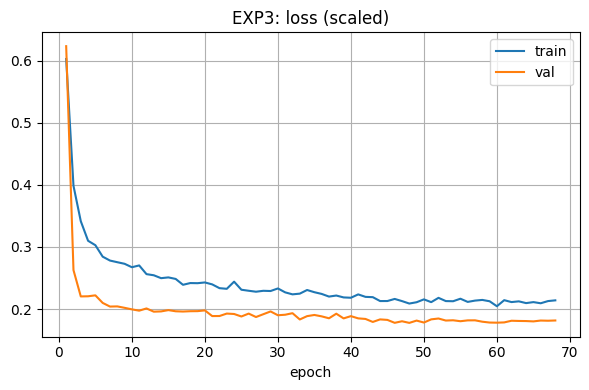

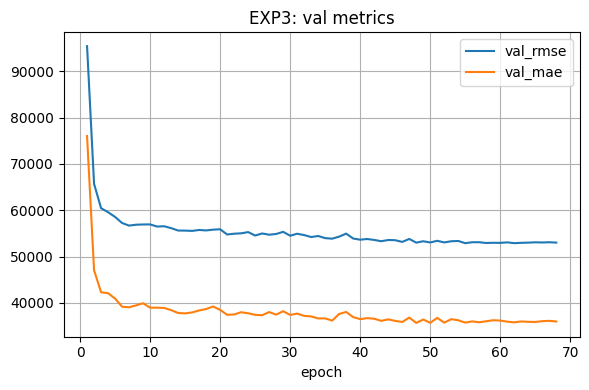

In [104]:
hd = pd.DataFrame(hist_e3)
plt.figure(figsize=(6,4))
plt.plot(hd["epoch"], hd["train_loss_s"], label="train")
plt.plot(hd["epoch"], hd["val_loss_s"],   label="val")
plt.title("EXP3: loss (scaled)"); plt.xlabel("epoch"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hd["epoch"], hd["val_rmse"], label="val_rmse")
plt.plot(hd["epoch"], hd["val_mae"],  label="val_mae")
plt.title("EXP3: val metrics"); plt.xlabel("epoch"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


**Čo som spravil**
- Trénoval som rovnaký MLP na rozšírených vstupoch.

**Výsledky (EUR)**
- Train **~49–50k**, Val **~52–53k / ~35–36k MAE / R² ~0.79**, Test **~52–53k / ~35–36k MAE / R² ~0.79**.

**Interpretácia**
- **Najlepší baseline**; Val ≈ Test → robustná generalizácia vďaka GEO.

### Hyperparameter search (grid/random)

In [105]:
assert Xtr_e3.shape[0] == len(y_train3_s)
assert Xva_e3.shape[0] == len(y_val3_s)
assert Xte_e3.shape[0] == len(y_test3_s)

y_scaler = y_scaler3
AMP_DTYPE = torch.float32

WANDB_GROUP = "EXP3-random"

N_TRIALS = 16
rows = []

In [106]:
search_space = {
    "hidden_layers": [[256,128,64], [256,128,64,32], [128,64,32]],
    "dropout":      [0.00, 0.05, 0.10, 0.15, 0.20],
    "batchnorm":    [True, False],
    "residual":     [False, True],
    "bottleneck":   [False, True],
    "optimizer":    ["adam","rmsprop","sgd"],
    "lr":           [3e-4, 1e-3],
    "weight_decay": [0.0, 1e-5, 1e-4],
    "batch_size":   [512, 1024, 2048],
    "patience":     [12, 16, 20],
}
def _pick(k):
    return random.choice(search_space[k])

In [107]:
for i in range(1, N_TRIALS+1):
    cfg = DEFAULT_CFG |{
        "hidden_layers": _pick("hidden_layers"),
        "dropout":      _pick("dropout"),
        "batchnorm":    _pick("batchnorm"),
        "residual":     _pick("residual"),
        "bottleneck":   _pick("bottleneck"),
        "optimizer":    _pick("optimizer"),
        "lr":           _pick("lr"),
        "weight_decay": _pick("weight_decay"),
        "batch_size":   _pick("batch_size"),
        "patience":     _pick("patience"),
        "seed":         random.randint(1, 100_000),
        "feature_set":  CONFIG_E3["feature_set"],
    }

    _, _, res = run_experiment(
        cfg,
        Xtr_e3, y_train3_s, Xva_e3, y_val3_s, Xte_e3, y_test3_s,
        wandb_tags=[CONFIG_E3["feature_set"], "random", "EXP3_geo"],
        run_name=f"EXPERIMENT3-random-{i:02d}"
    )

    rows.append({
        "i": i,
        "val_rmse":  res["val"]["rmse"],  "test_rmse":  res["test"]["rmse"],
        "val_mae":   res["val"]["mae"],   "test_mae":   res["test"]["mae"],
        "val_r2":    res["val"]["r2"],    "test_r2":    res["test"]["r2"],
        "cfg": cfg
    })

In [108]:
df_rand = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
display(df_rand[["i","val_rmse","test_rmse","val_mae","test_mae","val_r2","test_r2"]].head(10).round(2))
print("\nNajlepší random podľa test_rmse:\n", df_rand.iloc[0]["cfg"])

,i,val_rmse,test_rmse,val_mae,test_mae,val_r2,test_r2
0,1,52200.76,51982.09,34863.48,34637.98,0.80,0.79
1,3,53467.01,52931.83,36621.95,36207.17,0.79,0.79
2,12,52756.79,52942.74,34810.25,35117.98,0.79,0.79
3,4,53879.36,53301.43,37449.65,37087.46,0.78,0.78
4,14,54794.41,54836.19,36848.83,36923.93,0.78,0.77
5,5,55232.77,54856.29,37531.84,37490.34,0.77,0.77
6,9,55769.62,55084.78,38683.95,38356.59,0.77,0.77
7,15,55555.91,55158.04,38455.66,38433.46,0.77,0.77
8,6,55372.21,55357.55,37498.36,37780.49,0.77,0.77
9,2,55476.99,55426.52,37535.20,37309.23,0.77,0.77



Najlepší random podľa test_rmse:
 {'seed': 32707, 'hidden_layers': [256, 128, 64], 'batchnorm': True, 'dropout': 0.15, 'residual': False, 'bottleneck': True, 'optimizer': 'rmsprop', 'lr': 0.0003, 'weight_decay': 1e-05, 'batch_size': 512, 'epochs': 200, 'patience': 20, 'grad_clip': 1.0, 'feature_set': 'exp3_allnum_geo'}


In [109]:
assert Xtr_e3.shape[0] == len(y_train3_s)
assert Xva_e3.shape[0] == len(y_val3_s)
assert Xte_e3.shape[0] == len(y_test3_s)

WANDB_GROUP = "EXP3-grid"

In [110]:
candidate_grid = {
    "hidden_layers": [[256,128,64], [128,64,32]],
    "dropout":       [0.05, 0.10],
    "optimizer":     ["adam","rmsprop"],
    "lr":            [1e-3, 3e-4],
    "weight_decay":  [1e-5],
    "batch_size":    [1024],
    "patience":      [16],
}

gkeys = list(candidate_grid.keys())
gvals = list(candidate_grid.values())

rows = []
idx = 1

In [111]:
for values in product(*gvals):
    cfg = DEFAULT_CFG | {k: v for k, v in zip(gkeys, values)} | {
        "feature_set": CONFIG_E3["feature_set"],
        "seed": 42 + idx,
    }

    _, _, res = run_experiment(
        cfg,
        Xtr_e3, y_train3_s, Xva_e3, y_val3_s, Xte_e3, y_test3_s,
        wandb_tags=[CONFIG_E3["feature_set"], "grid-24", "EXP3_geo"],
        run_name=f"EXPERIMENT3-grid-{idx:02d}"
    )

    rows.append({
        "i": idx,
        "val_rmse":  res["val"]["rmse"],
        "test_rmse": res["test"]["rmse"],
        "val_mae":   res["val"]["mae"],
        "test_mae":  res["test"]["mae"],
        "val_r2":    res["val"]["r2"],
        "test_r2":   res["test"]["r2"],
        "cfg": cfg
    })
    idx += 1

In [112]:
df_grid24 = pd.DataFrame(rows).sort_values("test_rmse").reset_index(drop=True)
display(df_grid24[["i","val_rmse","test_rmse","val_mae","test_mae","val_r2","test_r2"]].head(10).round(2))
print("\nNajlepší grid podľa test_rmse:\n", df_grid24.iloc[0]["cfg"])

,i,val_rmse,test_rmse,val_mae,test_mae,val_r2,test_r2
0,1,49233.66,49306.96,31749.07,31401.44,0.82,0.82
1,3,50715.01,50760.66,33081.49,33030.86,0.81,0.80
2,5,51744.96,51395.43,34778.08,34327.30,0.80,0.80
3,4,52063.84,52132.87,34464.29,34116.51,0.80,0.79
4,7,51887.34,52412.87,34846.62,34927.98,0.80,0.79
5,11,52925.28,52535.75,35500.35,35339.98,0.79,0.79
6,8,53047.28,52831.57,35405.67,35539.93,0.79,0.79
7,13,53262.09,53074.62,36198.43,36407.70,0.79,0.79
8,2,53228.40,53156.32,35860.56,35745.72,0.79,0.79
9,15,53242.44,53259.51,35997.20,36169.20,0.79,0.78



Najlepší grid podľa test_rmse:
 {'seed': 43, 'hidden_layers': [256, 128, 64], 'batchnorm': True, 'dropout': 0.05, 'residual': False, 'bottleneck': True, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 1e-05, 'batch_size': 1024, 'epochs': 200, 'patience': 16, 'grad_clip': 1.0, 'feature_set': 'exp3_allnum_geo'}


#### EXPERIMENT 3 — Hyperparameter search (random)
**Čo som spravil**
- Spustil som 16 náhodných behov na rozšírenom vstupe.

**Výsledky (EUR)**
- Najlepšie **Val ~52k**, **Test ~52k**.

**Interpretácia**
- Zisky citlivé najmä na dropout a LR; GEO prináša väčšinu prínosu.

#### EXPERIMENT 3 — Hyperparameter search (grid)
- Víťazných nastavena: vrstvy `[256,128,64]` / `[128,64,32]`,
  dropout **0.05–0.10**, **Adam**, **LR 1e-3**, **batch 1024**, **patience ~16**.

**Výsledky (EUR)**
- Najlepšie **Val ~49–50k**, **Test ~49–50k**.

**Interpretácia**
- Stabilné a opakovateľné; E3 je finálny model